# <i><u>L</u></i>anguage <i><u>L</u></i>earning (L-Squared) 

### Group 3
### Team members: Akshya Ramesh & Rathnapriya Gopalakrishnan

### **Purpose**

The main purpose of our project is to make the language learning process fun by using attractive visuals. We provide a way for people from different language backgrounds to learn other languages by translating them and connecting the words/sentences to their pictures. This facilitates **Visual Learning**  which helps in better memorizing and understanding the language.

Our project mainly covers three aspects of the NLP task namely: Language detection, language translation, and image retrieval. 

**User Scenario:**
    John wants to learn a new language say English. His native language is French. All he needs to do is enter the word/sentence that he wants to learn in French. Then the algorithm will provide the translation along with related pictures.

---

We had two approaches to achieve this:-

#### Method 1:  
In this method we built an LSTM-based neural network model and a transformer model and compared their performance

##### 1. LSTM
    - This method only accommodates French to English translation and image retrieval. 
    - We built a French-to-English-translation model using LSTM based neural network.
    - The results from this model were used for image retrieval from google using GoogleImageCrawler. 

**Data Source:** https://www.kaggle.com/datasets/harishreddy18/english-to-french

**Model:** We referred to the [Machine translation FR->EN with BLEU Score](https://www.kaggle.com/code/databeru/machine-translation-fr-en-with-bleu-score) code from Kaggle and made a few changes in hopes of improving the existing model. We trained the model on a new dataset with 50,000 records and also added two additional LSTM layers.

The major disadvantage of this model is not being able to use it for other languages. We would need to train the models with a variety of datasets from multiple languages which is time-consuming and needs a lot of memory and computational resources. In order to overcome this issue, we used pre-trained models like en_core_web_sm for language detection from spaCy, and textBlob for language translation to English.

##### 2. Transformer
    - We used in HuggingFace's pretrained transformer model (m2m100_418M)
    - This model supports Multi-language detection and translation 
    - The results from this model were used for image retrieval from google using GoogleImageCrawler. 

**Comparison:**
     - The transformer model performed much better than the LSTM model. The reason being transformers have better architecture and accuracy rate than LSTM. It is also difficult to train LSTM's large number of parameters under limited memory and computational resources.

---

#### Method 2: 
    - This method supports multiple language detection, translation and image retrieval
    - Used the python **spaCy** package for language detection
    - Used the python **TextBlob** package for language translation
    - Used GoogleImageCrawler to fetch images from google

This method was able to overcome the drawbacks of the previous method. Translation capability was very high compared to the model created in method 1. 

---

##### Dall-E Mini

We also tried to incorporate Dall-E Mini for image generation for the translated results instead of retrieving images from google. But we found that the images generated were contorted to a greater extent. We have also included images generated from Dall-E Mini for sample text prompts at the end for your reference. 

---

We will be using the sample french text "Le chien mange de la nourriture" which means "The dog is eating food" and try to translate it to english for each approach

---


# Method 1

### 1. Using LSTM

In [1]:
#importing the required packages from Keras, Pandas, Numpy, Matplotlib etc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential,load_model
from keras.layers import LSTM,Dense,Embedding,RepeatVector,TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.preprocessing.text import Tokenizer
from nltk.translate.bleu_score import corpus_bleu
from string import punctuation
from unicodedata import normalize

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Limiting the total number of records used due to memory and computational limitaions
total_sentences = 50000

# We used a new dataset to train our model
dataset = pd.read_csv("en_to_fr_combined.csv", encoding = "ISO-8859-1", header=None, index_col=False, names=['English words/sentences','French words/sentences'], nrows = total_sentences)

# Percentage of data used for testing the model
test_proportion = 0.2
train_test_threshold = int( (1-test_proportion) * total_sentences)


In [4]:
dataset.head()

,English words/sentences,French words/sentences
0,new jersey is sometimes quiet during autumn,new jersey est parfois calme pendant l' automne
1,the united states is usually chilly during july,les états-unis est généralement froid en juillet
2,california is usually quiet during march,california est généralement calme en mars
3,the united states is sometimes mild during june,les états-unis est parfois légé¨re en juin
4,your least liked fruit is the grape,votre moins aimé fruit est le raisin


In [5]:
dataset.dropna(inplace=True)

In [6]:
def clean(string):
    string = string.lower()  #converting sentences to lower case
    for p in punctuation + "«»" + "0123456789": # removing punctuations
        string = string.replace(p," ")
    string = re.sub('\s+',' ', string) # replacing multi-space with single space
    string = string.strip() #Removing trailing and leading spaces    
    return string

#  Data Cleaning
dataset["English words/sentences"] = dataset["English words/sentences"].apply(lambda x: clean(x))
dataset["French words/sentences"] = dataset["French words/sentences"].apply(lambda x: clean(x))
dataset = dataset.values
dataset = dataset[:total_sentences] # limiting the rows to the set threshold
train, test = dataset[:train_test_threshold], dataset[train_test_threshold:] #splitting the training and testing set
source_str, target_str = "French", "English" # setting the source and target language
idx_src, idx_tar = 1, 0 # Column number of source and target


In [7]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer
 
def max_len(lines):
    return max(len(line.split()) for line in lines) #returns the maximum sentence length

def encode_sequences(tokenizer, length, lines): #encodes to integer and pads with zeros
    X = tokenizer.texts_to_sequences(lines) 
    X = pad_sequences(X, maxlen=length, padding='post')
    return X
 
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = np.array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y
 
# Prepare target tokenizer
tar_tokenizer = create_tokenizer(dataset[:, idx_tar])
tar_vocab_size = len(tar_tokenizer.word_index) + 1
tar_length = max_len(dataset[:, idx_tar])
# Prepare source tokenizer
src_tokenizer = create_tokenizer(dataset[:, idx_src])
src_vocab_size = len(src_tokenizer.word_index) + 1
src_length = max_len(dataset[:, idx_src])
# Prepare training data
trainX = encode_sequences(src_tokenizer, src_length, train[:, idx_src])
trainY = encode_sequences(tar_tokenizer, tar_length, train[:, idx_tar])
trainY = encode_output(trainY, tar_vocab_size)
# Prepare test data
testX = encode_sequences(src_tokenizer, src_length, test[:, idx_src])
testY = encode_sequences(tar_tokenizer, tar_length, test[:, idx_tar])
testY = encode_output(testY, tar_vocab_size)

In [8]:
# Model Creation
def create_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model
model = create_model(src_vocab_size, tar_vocab_size, src_length, tar_length, 256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
history = model.fit(trainX, 
          trainY, 
          epochs=100, 
          batch_size=64, 
          validation_split=0.1, 
          verbose=1,
          callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])

Epoch 1/100
563/563 [==============================] - 109s 181ms/step - loss: 1.4319 - val_loss: 0.8636
Epoch 2/100
563/563 [==============================] - 102s 182ms/step - loss: 0.9216 - val_loss: 0.7713
Epoch 3/100
563/563 [==============================] - 96s 171ms/step - loss: 0.6914 - val_loss: 0.6561
Epoch 4/100
563/563 [==============================] - 96s 170ms/step - loss: 0.5999 - val_loss: 0.5736
Epoch 5/100
563/563 [==============================] - 95s 169ms/step - loss: 0.5634 - val_loss: 0.5266
Epoch 6/100
563/563 [==============================] - 97s 172ms/step - loss: 0.5504 - val_loss: 0.6340
Epoch 7/100
563/563 [==============================] - 97s 172ms/step - loss: 0.5259 - val_loss: 0.5088
Epoch 8/100
563/563 [==============================] - 97s 172ms/step - loss: 0.5127 - val_loss: 0.4947
Epoch 9/100
563/563 [==============================] - 97s 172ms/step - loss: 0.5604 - val_loss: 0.6152
Epoch 10/100
563/563 [==============================] - 97s 17

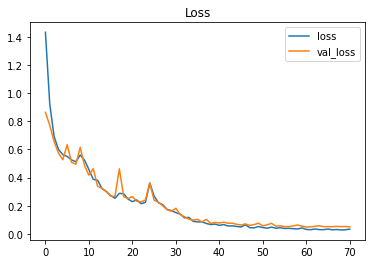

In [9]:
# Performance evaluation
pd.DataFrame(history.history).plot()
plt.title("Loss")
plt.show()

In [10]:
# Results on test set
def word_for_id(integer, tokenizer): # word to int mapping
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
 
def predict_seq(model, tokenizer, source): # prediction to english
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

def compare_prediction(model, tokenizer, sources, raw_dataset, limit=10): #Results
    actual, predicted = [], []
    src = f'{source_str.upper()} (Source Lang) ||'
    tgt = f'{target_str.upper()} (Target Lang) ||'
    pred = f'Prediction {target_str.upper()}'
    print(f'{src:30} {tgt:25} {pred}\n')
    for i, source in enumerate(sources): # translate encoded source text
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq(model, tar_tokenizer, source)
        raw_target, raw_src = raw_dataset[i]
        print(f'{raw_src:30} {raw_target:25} {translation}')
        if i >= limit: 
            break
 
print('Results')
compare_prediction(model, tar_tokenizer, testX, test)

Results
FRENCH (Source Lang) ||        ENGLISH (Target Lang) ||  Prediction ENGLISH

son fruit préféré est moins la mangue his least favorite fruit is the mango his least favorite fruit is the mango
chine est merveilleux en automne china is wonderful during autumn china is wonderful during autumn
la france est le gel en mai    france is freezing during may france is freezing during may
son animal préféré est ce lapin his favorite animal is this rabbit his favorite animal is that rabbit
la chine est parfois occupé au mois de mai china is sometimes busy during may china is sometimes busy during may
il voulait aller au new jersey en mai dernier he wanted to go to new jersey last may he wanted to go to new jersey last may
la poire est leur fruit le plus cher the pear is their most loved fruit the pear is their most loved fruit
mon fruit préféré moins est la péªche my least favorite fruit is the peach my least favorite fruit is the peach
l inde est jamais é sec en octobre india is never dry

In [11]:
sample_text=[]
for i in range(1):
    sample_text.append(input("Enter the sentence in French:-"))
src_length_1 = max_len(sample_text)
test_1 = encode_sequences(src_tokenizer, src_length_1, sample_text)

Enter the sentence in French:-Le chien mange de la nourriture


In [12]:
def predict_seq_test(model, tokenizer, source):
    prediction = model.predict(source, verbose=0)[0]
    integers = [np.argmax(vector) for vector in prediction]
    target = list()
    for i in integers:
        word = word_for_id(i, tokenizer)
        if word is None:
            break
        target.append(word)
    return ' '.join(target)

In [13]:
def compare_prediction_test(model, tokenizer, sources, limit=20):
    actual, predicted = [], []
    for i, source in enumerate(sources): 
        source = source.reshape((1, source.shape[0]))
        translation = predict_seq_test(model, tar_tokenizer, source)
        return translation
        if i >= limit: 
            break

In [14]:
print("Source Text:",str(sample_text[0]))
translated_val = compare_prediction_test(model, tar_tokenizer, test_1)
print("Translated Text:",translated_val)

Source Text: Le chien mange de la nourriture
Translated Text: he likes big bananas bananas


### Image Retrieval

In [15]:
#importing GoogleImageCrawler as gc to crawl google images
from icrawler.builtin import GoogleImageCrawler as gc

g_crawler = gc(parser_threads=2, 
    downloader_threads=4,
    storage={'root_dir': 'ImageDirectory'}) #The downloaded images are stored in the ImageDirectory folder

g_crawler.crawl(keyword=translated_val,max_num=5); #The top 5 images that matches the translated text will be stored in the directory

2022-07-15 15:00:38,353 - INFO - icrawler.crawler - start crawling...
2022-07-15 15:00:38,354 - INFO - icrawler.crawler - starting 1 feeder threads...
2022-07-15 15:00:38,355 - INFO - feeder - thread feeder-001 exit
2022-07-15 15:00:38,357 - INFO - icrawler.crawler - starting 2 parser threads...
2022-07-15 15:00:38,360 - INFO - icrawler.crawler - starting 4 downloader threads...
2022-07-15 15:00:39,898 - INFO - parser - parsing result page https://www.google.com/search?q=he+likes+big+bananas+bananas&ijn=0&start=0&tbs=&tbm=isch
2022-07-15 15:00:40,109 - ERROR - downloader - Response status code 403, file https://external-preview.redd.it/Lq1nVNwvuNslZ9zCdAapp6P7XqDyP-RXqvOxnObLuCE.jpg
2022-07-15 15:00:40,134 - ERROR - downloader - Response status code 403, file https://preview.redd.it/cq90ojrzr6e41.jpg
2022-07-15 15:00:40,370 - INFO - parser - no more page urls for thread parser-002 to parse
2022-07-15 15:00:40,375 - INFO - parser - thread parser-002 exit
2022-07-15 15:00:40,380 - INFO -

2022-07-15 15:00:42,897 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2022-07-15 15:00:42,897 - INFO - parser - thread parser-001 exit


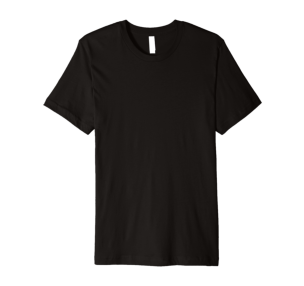

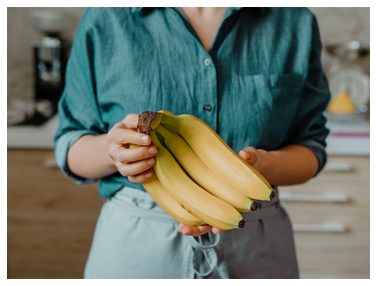

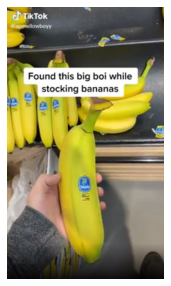

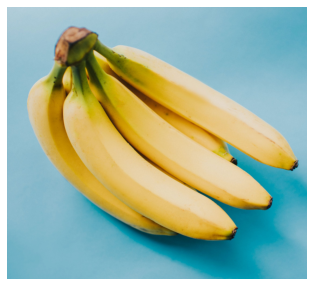

In [16]:
import os
import matplotlib.pyplot as plt
directory="C:/Users/Priya/ImageDirectory" #The path of ImageDirectory folder
file_names=os.listdir(directory)
image_paths = [os.path.join(directory + "/" + i) for i in file_names] #Obtaining the path of each jpeg file 
k=0
for i in image_paths[1:]:
    k=k+1
    plt.figure(figsize=(10,5))
    plt.imshow(plt.imread(i))
    plt.axis('off')
plt.show() #Displaying the images

#Emptying the ImageDirectory
import shutil
try:
    shutil.rmtree(directory)
except OSError as e:
    print("Directory path not found")

### 2. Using Transformers


In [17]:
from transformers import pipeline
pipe = pipeline(task='text2text-generation', model='facebook/m2m100_418M')

## User inputs
- The user should provide source text (eg. "Le chien mange de la nourriture")  
- And the target language code        (eg. en - english, fr - french, hi - hindi, es - spanish, zh - chinese etc)  
For more language codes refer [here](https://developers.google.com/admin-sdk/directory/v1/languages)

In [18]:
# Converting the language to target language l
text = input("Enter the sentence in source language: ")
desti =  input("Enter the target lannguague:")
translated_text = pipe(text, forced_bos_token_id=pipe.tokenizer.get_lang_id(lang=desti))
translated_text = translated_text[0]['generated_text']
translated_text

Enter the sentence in source language: Le chien mange de la nourriture
Enter the target lannguague:en


'The dog eat the food'

### Image Retrieval

In [19]:
#importing GoogleImageCrawler as gc to crawl google images
from icrawler.builtin import GoogleImageCrawler as gc

g_crawler = gc(parser_threads=2, 
    downloader_threads=4,
    storage={'root_dir': 'ImageDirectory'}) #The downloaded images are stored in the ImageDirectory folder

g_crawler.crawl(keyword=translated_text,max_num=5); #The top 5 images that matches the translated text will be stored in the directory

2022-07-15 15:01:00,805 - INFO - icrawler.crawler - start crawling...
2022-07-15 15:01:00,805 - INFO - icrawler.crawler - starting 1 feeder threads...
2022-07-15 15:01:00,806 - INFO - feeder - thread feeder-001 exit
2022-07-15 15:01:00,808 - INFO - icrawler.crawler - starting 2 parser threads...
2022-07-15 15:01:00,812 - INFO - icrawler.crawler - starting 4 downloader threads...
2022-07-15 15:01:02,078 - INFO - parser - parsing result page https://www.google.com/search?q=The+dog+eat+the+food&ijn=0&start=0&tbs=&tbm=isch
2022-07-15 15:01:02,548 - INFO - downloader - image #1	https://www.akc.org/wp-content/uploads/2019/10/SHOT-02_53448-copy.jpg
2022-07-15 15:01:02,564 - INFO - downloader - image #2	https://cdn-prod.medicalnewstoday.com/content/images/articles/324/324453/dog-standing-on-kitchen-table-licking-mouth-while-family-cook-food-in-background.jpg
2022-07-15 15:01:02,675 - INFO - downloader - image #3	https://cdn-prd.content.metamorphosis.com/wp-content/uploads/sites/2/2020/01/shutt

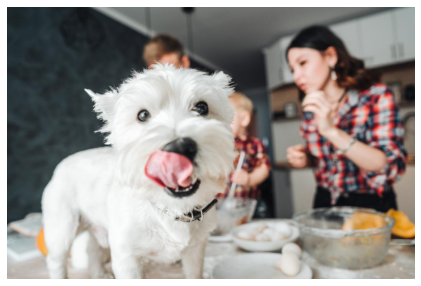

2022-07-15 15:01:05,139 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2022-07-15 15:01:05,140 - INFO - parser - thread parser-001 exit


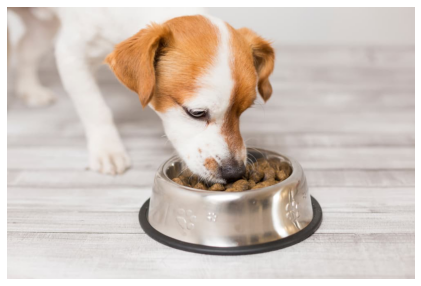

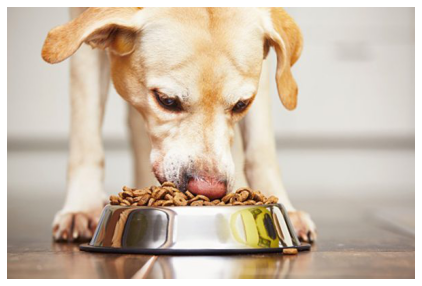

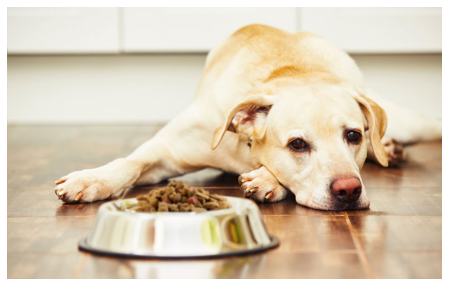

In [20]:
import os
import matplotlib.pyplot as plt
directory="C:/Users/Priya/ImageDirectory" #The path of ImageDirectory folder
file_names=os.listdir(directory)
image_paths = [os.path.join(directory + "/" + i) for i in file_names] #Obtaining the path of each jpeg file 
k=0
for i in image_paths[1:]:
    k=k+1
    plt.figure(figsize=(10,5))
    plt.imshow(plt.imread(i))
    plt.axis('off')
plt.show() #Displaying the images

#Emptying the ImageDirectory
import shutil
try:
    shutil.rmtree(directory)
except OSError as e:
    print("Directory path not found")

# Method 2

### 1. Language Detection

In [21]:
#Importing spaCy libraries 
import spacy
from spacy.language import Language
from spacy_langdetect import LanguageDetector

#Creating a function for the language detector as adding it directly is not allowed in the spaCy v3
def get_lang_detector(nlp, name):
    return LanguageDetector()

spacy_model = spacy.load("en_core_web_sm") #Loading the en_core_web_sm spaCy model
Language.factory("language_detector", func=get_lang_detector) #Assigning a name to the pipeline component factory
spacy_model.add_pipe('language_detector', last=True) #The component is now added to the pipeline

## User inputs
- The user should provide source text (eg. "Le chien mange de la nourriture")  
- And the target language code        (eg. en - english, fr - french, hi - hindi, es - spanish, zh - chinese etc)  
For more language codes refer [here](https://developers.google.com/admin-sdk/directory/v1/languages)

In [22]:
#Obtaining user input and detecting the source language
text = input("Enter the sentence in source language: ")
desti =  input("Enter the target lannguague:")

p_text = spacy_model(text)
lang = p_text._.language['language']
print("The detected language is:",lang)

Enter the sentence in source language: Le chien mange de la nourriture
Enter the target lannguague:en
The detected language is: fr


### 2. Language Translation 

In [23]:
#Importing textBlob package
from textblob import TextBlob

tb_model = TextBlob(text) #Invoking the TextBlob constructor

translated_val = tb_model.translate(from_lang=lang, to=desti) #Translating to English
print(translated_val)

The dog eats food


### 3. Image Retrieval

In [24]:
%%capture out
#importing GoogleImageCrawler as gc to crawl google images
from icrawler.builtin import GoogleImageCrawler as gc

g_crawler = gc(parser_threads=2, 
    downloader_threads=4,
    storage={'root_dir': 'ImageDirectory'}) #The downloaded images are stored in the ImageDirectory folder

g_crawler.crawl(keyword=translated_val,max_num=5); #The top 5 images that matches the translated text will be stored in the directory

2022-07-15 15:01:11,743 - INFO - icrawler.crawler - start crawling...
2022-07-15 15:01:11,745 - INFO - icrawler.crawler - starting 1 feeder threads...
2022-07-15 15:01:11,747 - INFO - feeder - thread feeder-001 exit
2022-07-15 15:01:11,748 - INFO - icrawler.crawler - starting 2 parser threads...
2022-07-15 15:01:11,751 - INFO - icrawler.crawler - starting 4 downloader threads...
2022-07-15 15:01:13,006 - INFO - parser - parsing result page https://www.google.com/search?q=The+dog+eats+food&ijn=0&start=0&tbs=&tbm=isch
2022-07-15 15:01:13,305 - INFO - downloader - image #1	https://cdn-prod.medicalnewstoday.com/content/images/articles/324/324453/dog-eating-from-food-bowl.jpg
2022-07-15 15:01:13,374 - INFO - downloader - image #2	https://cdn-prd.content.metamorphosis.com/wp-content/uploads/sites/2/2020/01/shutterstock_1082072867-2.jpg
2022-07-15 15:01:13,415 - INFO - downloader - image #3	https://www.akc.org/wp-content/uploads/2019/10/SHOT-02_53448-copy.jpg
2022-07-15 15:01:13,626 - INFO - 

2022-07-15 15:01:14,866 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2022-07-15 15:01:14,867 - INFO - parser - thread parser-001 exit


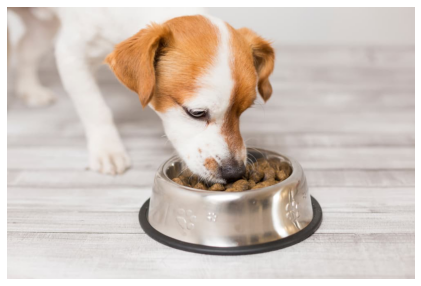

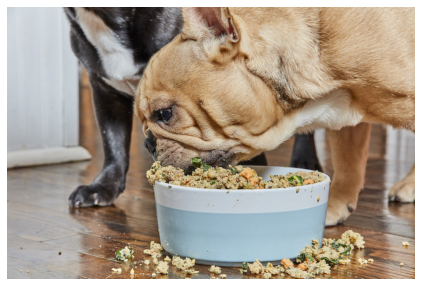

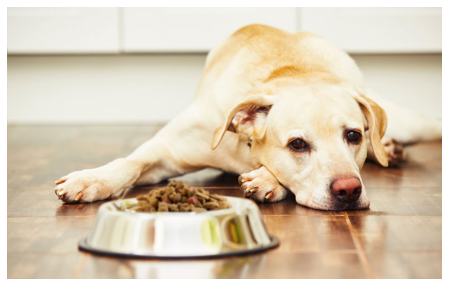

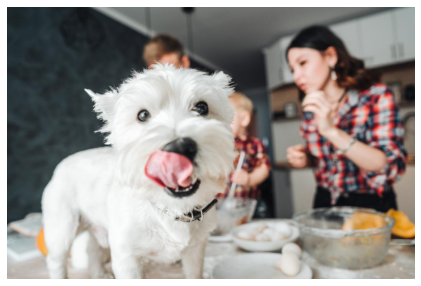

In [25]:
import os
import matplotlib.pyplot as plt
directory="C:/Users/Priya/ImageDirectory" #The path of ImageDirectory folder
file_names=os.listdir(directory)
image_paths = [os.path.join(directory + "/" + i) for i in file_names] #Obtaining the path of each jpeg file 
k=0
for i in image_paths[1:]:
    k=k+1
    plt.figure(figsize=(10,5))
    plt.imshow(plt.imread(i))
    plt.axis('off')
plt.show() #Displaying the images

#Emptying the ImageDirectory
import shutil
try:
    shutil.rmtree(directory)
except OSError as e:
    print("Directory path not found")

## Dall-E Mini

Image generated from Dall-E Mini for the prompt **"Dog eating food"**

(-0.5, 360.5, 666.5, -0.5)

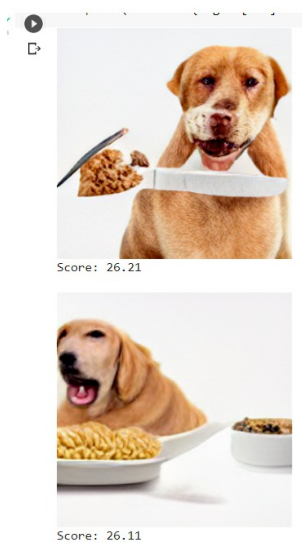

In [31]:

plt.figure(figsize=(15,10))
dalle_img = plt.imread("dalle-mini.jpeg")
plt.imshow(dalle_img)
plt.axis('off')

### References:  
- https://www.kaggle.com/datasets/harishreddy18/english-to-french
- https://www.kaggle.com/code/databeru/machine-translation-fr-en-with-bleu-score
- https://pypi.org/project/dalle-mini/
- https://www.theclickreader.com/language-translation-using-hugging-face-and-python/
- https://spacy.io/
- https://textblob.readthedocs.io/en/dev/
- https://pypi.org/project/icrawler/